In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

## IP Adapter FaceID
* [*IP Adapter* Github Repository](https://github.com/tencent-ailab/IP-Adapter)
* [*IP Adaper FaceID* HuggingFace Repository](https://huggingface.co/h94/IP-Adapter-FaceID)

In [2]:
import os
from typing import List
import cv2
import matplotlib.pyplot as plt
import torch
from diffusers import AutoencoderKL, DDIMScheduler, StableDiffusionPipeline
from insightface.app import FaceAnalysis
from insightface.utils import face_align
from ip_adapter.ip_adapter_faceid import IPAdapterFaceID, IPAdapterFaceIDPlus
from PIL import Image

In [3]:
def display_images(
    images: List[Image.Image],
    n_columns: int = 3,
    fig_size: int = 20,
) -> None:
    n_columns = min(len(images), n_columns)
    quotient, remainder = divmod(len(images), n_columns)
    if remainder > 0:
        quotient += 1
    width, height = images[0].size
    plt.figure(figsize=(fig_size, fig_size / n_columns * quotient * height / width))
    for i, image in enumerate(images):
        plt.subplot(quotient, n_columns, i + 1)
        plt.axis("off")
        plt.imshow(image, aspect="auto")
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [4]:
IMAGE_DIR = "images"
IMAGE_FILENAME = "sample.jpg"

BASE_MODEL_PATH = "SG161222/Realistic_Vision_V4.0_noVAE"
VAE_MODEL_PATH = "stabilityai/sd-vae-ft-mse"
IMAGE_ENCODER_PATH = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"

MODEL_DIR = "models"
CKPT = "ip-adapter-faceid_sd15.bin"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(640, 640))

image_path = os.path.join(os.pardir, IMAGE_DIR, IMAGE_FILENAME)
image = cv2.imread(image_path)
faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
face_image = face_align.norm_crop(image, landmark=faces[0].kps, image_size=224)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ec2-user/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ec2-user/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ec2-user/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ec2-user/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ec2-user/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [6]:
scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

vae = AutoencoderKL.from_pretrained(VAE_MODEL_PATH).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL_PATH,
    torch_dtype=torch.float16,
    scheduler=scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None,
)

model = IPAdapterFaceID(pipe, os.path.join(os.pardir, MODEL_DIR, CKPT), device)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
PROMPT = "a photo of a man as the ironman"
NEGATIVE_PROMPT = "bad anatomy, blurry, low quality, lowres, monochrome, worst quality"

images = model.generate(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    faceid_embeds=faceid_embeds,
    num_samples=4,
    width=512,
    height=768,
    num_inference_steps=30,
    seed=42,
)

  0%|          | 0/30 [00:00<?, ?it/s]

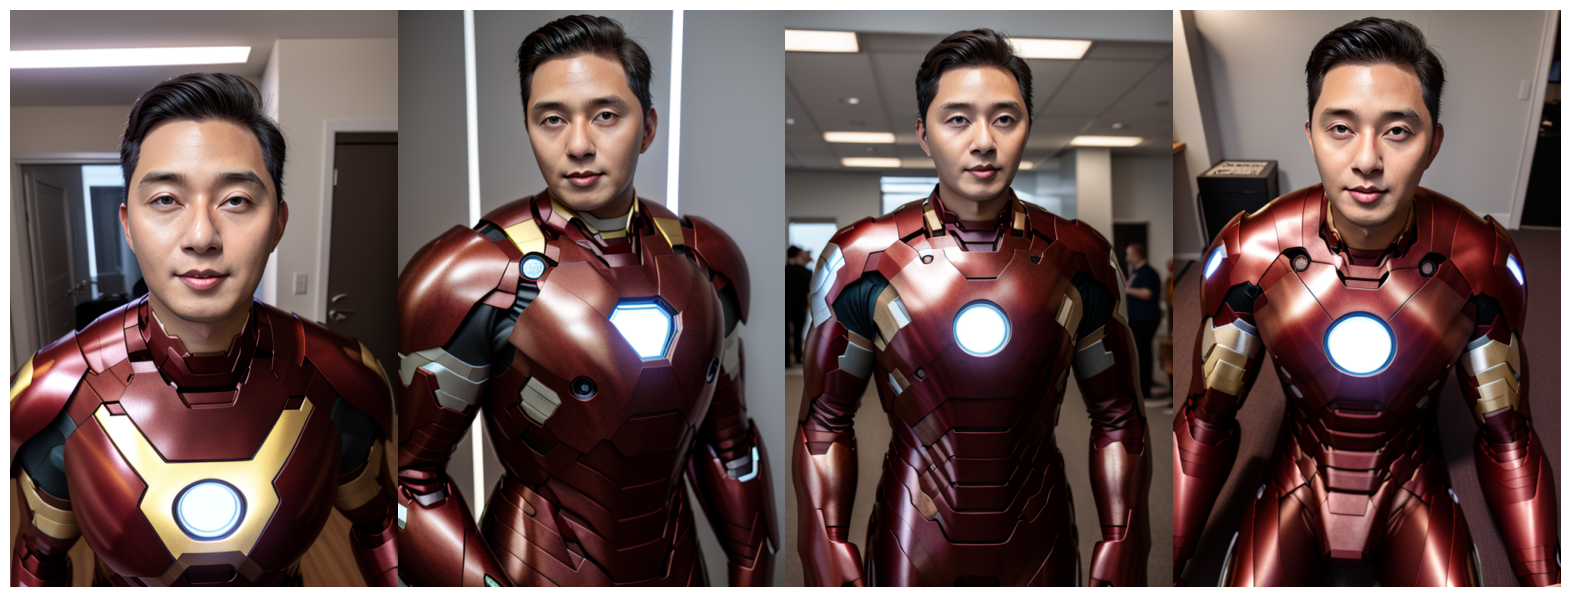

In [8]:
display_images(images, 4)

In [9]:
USE_SHORTCUT = False
CKPT = (
    "ip-adapter-faceid-plusv2_sd15.bin"
    if USE_SHORTCUT
    else "ip-adapter-faceid-plus_sd15.bin"
)

scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

vae = AutoencoderKL.from_pretrained(VAE_MODEL_PATH).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL_PATH,
    torch_dtype=torch.float16,
    scheduler=scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None,
)

model = IPAdapterFaceIDPlus(
    pipe, IMAGE_ENCODER_PATH, os.path.join(os.pardir, MODEL_DIR, CKPT), device
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
images = model.generate(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    face_image=face_image,
    faceid_embeds=faceid_embeds,
    shortcut=USE_SHORTCUT,
    s_scale=1.0,
    num_samples=4,
    width=512,
    height=768,
    num_inference_steps=30,
    seed=42,
)

  0%|          | 0/30 [00:00<?, ?it/s]

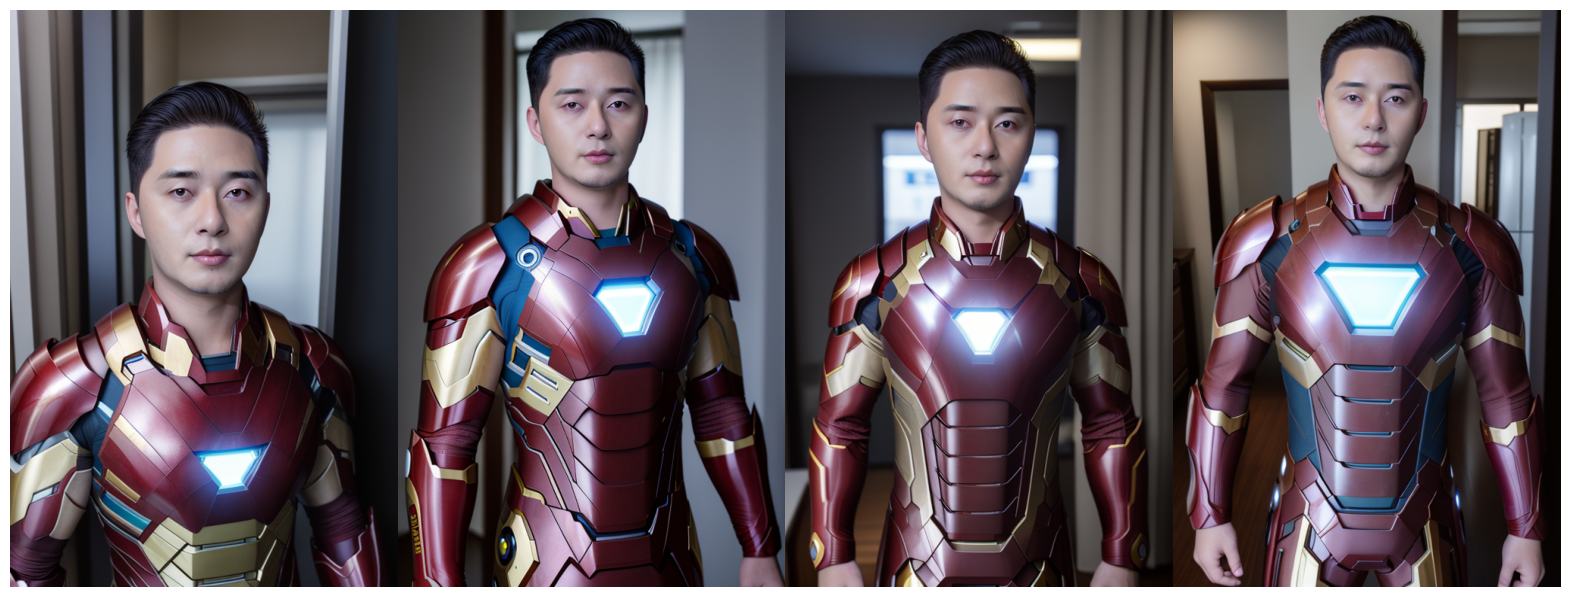

In [11]:
display_images(images, n_columns=4)